In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal
from sklearn.preprocessing import StandardScaler

In [3]:
df=pd.read_csv(r"C:\Users\shasw\OneDrive\Desktop\EEG-Neuromarkiting-Project\combined_text_files.csv")

In [10]:
def extract_frequency_features_from_structured_data(df):
    """
    Extract frequency band features from structured EEG data where each row is a time point.
    Groups data by name and product, then extracts frequency features for each group.
    """
    
    # Define frequency bands
    bands = {
        'delta': (1, 4),
        'theta': (4, 8),
        'alpha': (8, 13),
        'beta': (13, 30),
        'gamma': (30, 45)
    }
    
    # Sampling frequency (Hz)
    fs = 250
    
    # List to store processed data
    processed_data = []
    
    # Group data by name and product
    grouped = df.groupby(['name', 'product', 'label'])
    
    # Process each group (i.e., each person-product combination)
    for (name, product, label), group in grouped:
        # Extract EEG data for all time points
        eeg_data = group.filter(regex='^feature_').values
        
        # Number of channels (features)
        n_channels = eeg_data.shape[1]
        
        # Container for features
        channel_features = []
        
        # Process each channel
        for ch in range(n_channels):
            # Get data for this channel across all time points
            channel_data = eeg_data[:, ch]
            
            # Apply bandpass filter
            b, a = signal.butter(4, [1/(fs/2), 45/(fs/2)], btype='band')
            filtered_data = signal.filtfilt(b, a, channel_data)
            
            # Calculate power spectral density
            freqs, psd = signal.welch(filtered_data, fs, nperseg=min(256, len(filtered_data)))
            
            # Calculate band powers
            band_features = []
            for band_name, (low, high) in bands.items():
                idx_band = np.logical_and(freqs >= low, freqs <= high)
                band_power = np.mean(psd[idx_band])
                band_features.append(band_power)
            
            # Add band power features for this channel
            channel_features.extend(band_features)
        
        # Add processed data to our dataset
        processed_data.append({
            'name': name,
            'product': product,
            'EEG_Features': np.array(channel_features),
            'Label': 1 if label == 'Like' else 0  # Convert to binary label
        })
    
    # Create processed dataframe
    processed_df = pd.DataFrame(processed_data)
    
    # Normalize the features
    scaler = StandardScaler()
    # First create a 2D array from our feature list
    feature_matrix = np.array([feat for feat in processed_df['EEG_Features']])
    normalized_features = scaler.fit_transform(feature_matrix)
    
    # Create a copy with the normalized features
    processed_df_normalized = processed_df.copy()
    # Update with normalized features
    for i in range(len(processed_df)):
        processed_df_normalized.at[i, 'EEG_Features'] = normalized_features[i]
    
    return processed_df_normalized

In [11]:
def process_excel_data(excel_df):
    """Process data from Excel format and extract frequency features"""
    
    # Apply frequency feature extraction
    processed_df = extract_frequency_features_from_structured_data(excel_df)
    
    # Display information about the processed data
    print(f"Original dataset size: {len(excel_df)} rows")
    print(f"Processed dataset size: {len(processed_df)} samples (unique person-product combinations)")
    print(f"Feature vector size: {len(processed_df.iloc[0]['EEG_Features'])} features per sample")
    
    # Get class distribution
    class_distribution = processed_df['Label'].value_counts()
    print("\nClass distribution:")
    print(f"Like: {class_distribution.get(1, 0)} samples")
    print(f"Dislike: {class_distribution.get(0, 0)} samples")
    
    return processed_df

In [8]:
def visualize_eeg_features(processed_df, n_channels=14, n_bands=5):
    """Visualize the extracted frequency features"""
    
    # Get average features for each class
    like_features = np.vstack(processed_df[processed_df['Label'] == 1]['EEG_Features'].values)
    dislike_features = np.vstack(processed_df[processed_df['Label'] == 0]['EEG_Features'].values)
    
    like_avg = np.mean(like_features, axis=0)
    dislike_avg = np.mean(dislike_features, axis=0)
    
    # Reshape to (channels, bands)
    like_reshaped = like_avg.reshape(n_channels, n_bands)
    dislike_reshaped = dislike_avg.reshape(n_channels, n_bands)
    
    # Band names
    band_names = ['Delta', 'Theta', 'Alpha', 'Beta', 'Gamma']
    
    # Create figure for heatmaps
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # Plot average band powers for "Like"
    im0 = axes[0].imshow(like_reshaped, cmap='viridis', aspect='auto')
    axes[0].set_title('Average Band Powers - Like')
    axes[0].set_xlabel('Frequency Band')
    axes[0].set_ylabel('EEG Channel')
    axes[0].set_xticks(np.arange(n_bands))
    axes[0].set_xticklabels(band_names)
    axes[0].set_yticks(np.arange(n_channels))
    axes[0].set_yticklabels([f'Ch {i}' for i in range(n_channels)])
    plt.colorbar(im0, ax=axes[0], label='Normalized Power')
    
    # Plot average band powers for "Dislike"
    im1 = axes[1].imshow(dislike_reshaped, cmap='viridis', aspect='auto')
    axes[1].set_title('Average Band Powers - Dislike')
    axes[1].set_xlabel('Frequency Band')
    axes[1].set_yticks(np.arange(n_channels))
    axes[1].set_yticklabels([f'Ch {i}' for i in range(n_channels)])
    axes[1].set_xticks(np.arange(n_bands))
    axes[1].set_xticklabels(band_names)
    plt.colorbar(im1, ax=axes[1], label='Normalized Power')
    
    # Plot differences
    diff = like_reshaped - dislike_reshaped
    im2 = axes[2].imshow(diff, cmap='coolwarm', aspect='auto')
    axes[2].set_title('Difference (Like - Dislike)')
    axes[2].set_xlabel('Frequency Band')
    axes[2].set_yticks(np.arange(n_channels))
    axes[2].set_yticklabels([f'Ch {i}' for i in range(n_channels)])
    axes[2].set_xticks(np.arange(n_bands))
    axes[2].set_xticklabels(band_names)
    plt.colorbar(im2, ax=axes[2], label='Power Difference')
    
    plt.tight_layout()
    plt.show()
    
    # Create bar plots for specific channels
    # Select some channels to display (e.g., channels 0, 4, 8, 12)
    display_channels = [0, 4, 8, 12]
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    axes = axes.flatten()
    
    for i, ch in enumerate(display_channels):
        ax = axes[i]
        
        # Get band powers for this channel
        like_ch = like_reshaped[ch, :]
        dislike_ch = dislike_reshaped[ch, :]
        
        # Set up bar positions
        x = np.arange(n_bands)
        width = 0.35
        
        # Create bars
        ax.bar(x - width/2, like_ch, width, label='Like', color='blue', alpha=0.7)
        ax.bar(x + width/2, dislike_ch, width, label='Dislike', color='red', alpha=0.7)
        
        # Add labels
        ax.set_title(f'Channel {ch}')
        ax.set_xlabel('Frequency Band')
        ax.set_ylabel('Normalized Power')
        ax.set_xticks(x)
        ax.set_xticklabels(band_names)
        ax.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Statistical analysis
    # Calculate t-test for each feature
    from scipy import stats
    
    t_values = []
    p_values = []
    
    for i in range(like_features.shape[1]):
        t, p = stats.ttest_ind(like_features[:, i], dislike_features[:, i], equal_var=False)
        t_values.append(t)
        p_values.append(p)
    
    # Reshape to (channels, bands)
    t_values_reshaped = np.array(t_values).reshape(n_channels, n_bands)
    p_values_reshaped = np.array(p_values).reshape(n_channels, n_bands)
    
    # Plot p-values
    plt.figure(figsize=(10, 8))
    im = plt.imshow(-np.log10(p_values_reshaped), cmap='hot', aspect='auto')
    plt.title('Statistical Significance (-log10(p-value))')
    plt.xlabel('Frequency Band')
    plt.ylabel('EEG Channel')
    plt.xticks(np.arange(n_bands), band_names)
    plt.yticks(np.arange(n_channels), [f'Ch {i}' for i in range(n_channels)])
    plt.colorbar(im, label='-log10(p-value)')
    plt.tight_layout()
    plt.show()
    
    # Print the top 5 most significant features
    flat_p_values = np.array(p_values)
    top_indices = np.argsort(flat_p_values)[:5]
    
    print("\nTop 5 most significant features:")
    for idx in top_indices:
        ch = idx // n_bands
        band = idx % n_bands
        p_val = flat_p_values[idx]
        print(f"Channel {ch}, {band_names[band]} Band: p-value = {p_val:.6f}")


In [12]:
processed_df = process_excel_data(df)

Original dataset size: 535040 rows
Processed dataset size: 991 samples (unique person-product combinations)
Feature vector size: 70 features per sample

Class distribution:
Like: 447 samples
Dislike: 544 samples


In [13]:
processed_df.head(10)

,name,product,EEG_Features,Label
0,Abhishek,1,"[-0.08485423155072311, -0.04243023582588485, -...",1
1,Abhishek,2,"[-0.11273429258255604, -0.11366124722643485, -...",1
2,Abhishek,3,"[-0.011406317245420631, 0.015218504714255203, ...",0
3,Abhishek,4,"[-0.11691237946679069, -0.1062724202711412, -0...",1
4,Abhishek,5,"[-0.10374463082481795, -0.09633012815997183, -...",0
5,Abhishek,6,"[-0.09439042104194606, -0.07976201883093682, -...",1
6,Abhishek,7,"[-0.11617402719042652, -0.10571191512360414, -...",0
7,Abhishek,8,"[-0.03103480634041084, -0.04462085340392289, -...",0
8,Abhishek,9,"[-0.10765463984597219, -0.11294279960178191, -...",1
9,Abhishek,10,"[-0.11063231995878203, -0.12527734150393183, -...",0


In [15]:
processed_df.to_csv("Preprocess.csv")

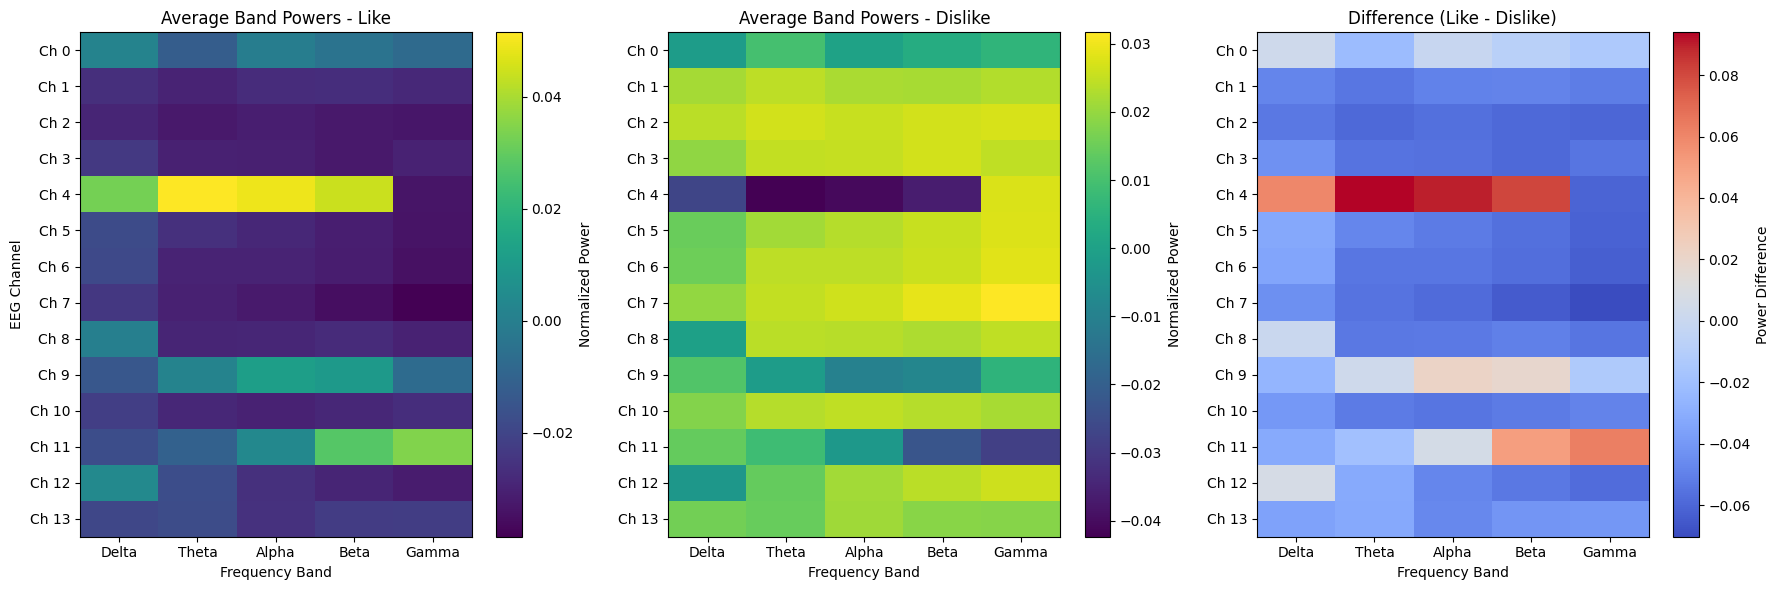

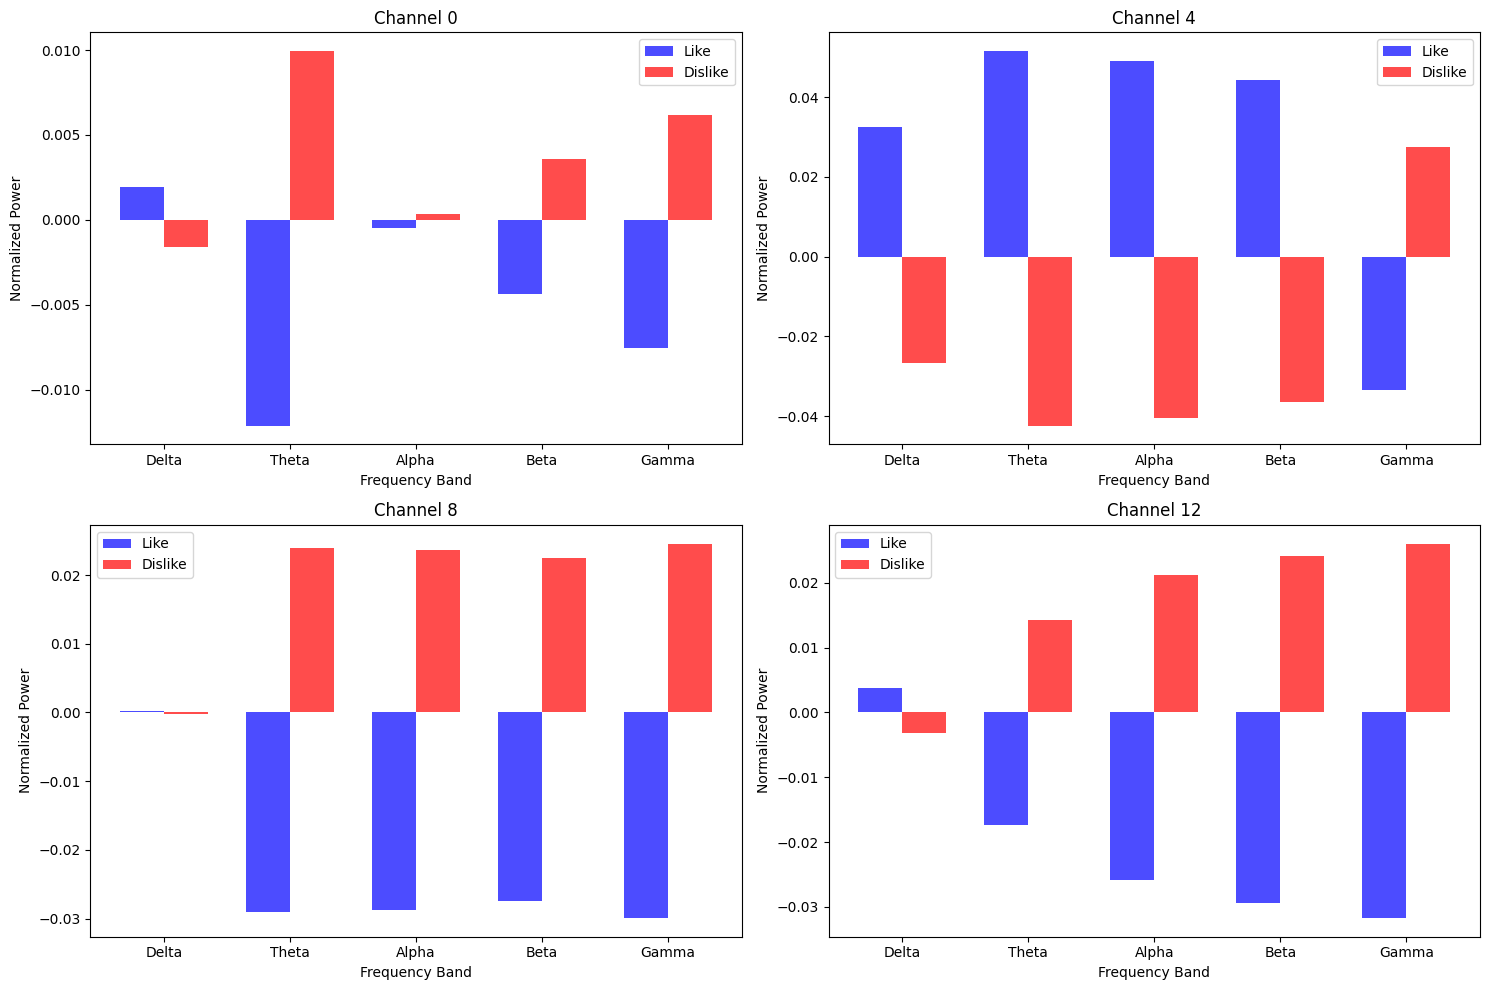

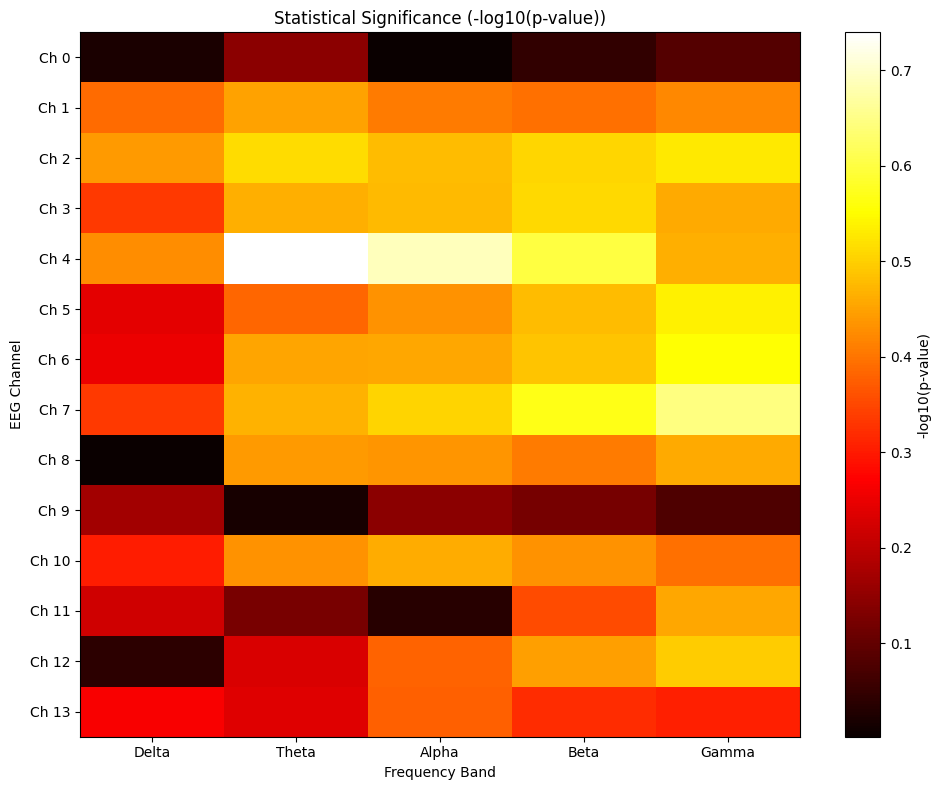


Top 5 most significant features:
Channel 4, Theta Band: p-value = 0.182044
Channel 4, Alpha Band: p-value = 0.204150
Channel 7, Gamma Band: p-value = 0.225651
Channel 4, Beta Band: p-value = 0.250520
Channel 7, Beta Band: p-value = 0.270180


In [16]:
visualize_eeg_features(processed_df)